In [2]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize, rosen
import sklearn.gaussian_process as gp
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel, RBF,ExpSineSquared 
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [22]:
lbound = -1
rbound = 2
X = np.arange(lbound,rbound, 0.01).reshape(-1, 1)
def function(X,noise=0):
  # return (-np.sin(3*X[:,0]) - X[:,0]**2 + 0.7*X[:,0] + noise * np.random.randn(*X[:,0].shape)).reshape(-1,1)
  # return (math.pow((x2-5.1/(4*math.pow(3.14,2))*math.pow(x1,2)+5/3.14*x1-6),2)+10*(1-1/(8*3.14))*math.cos(x1)+10)
  def func(x):
    return (math.pow((x[1]-5.1/(4*math.pow(3.14,2))*math.pow(x[0],2)+5/3.14*x[0]-6),2)+10*(1-1/(8*3.14))*math.cos(x[0])+10)
  return np.apply_along_axis(func, 1, X).reshape(-1,1)

function(np.array([[-0.36,1],[5,1]]))

array([[50.23458402],
       [12.79719765]])

In [15]:
a = np.linspace(-10,10,1000)
X = np.zeros((1000000,2))
c=0
for i in a:
  for j in a:
    X[c,0] = i
    X[c,1] = j
    c+=1
# a = a.reshape(-1,1)
l = function(X)
print(np.max(l),np.argmax(l))
function(np.array([[-100,-100]]))
# l

2013.9256356583692 0


array([2428602.58951614])

In [16]:
## return probability of improvement for random sample/s X
def PI(X,X_t,gpr,e):
  y_t = gpr.predict(X_t)
  X= np.expand_dims(X,axis=0)
  y,std = gpr.predict(X,return_std=True)
  
  std = std.reshape(-1,1)
  best_y = np.max(y_t)
  return norm.cdf((y-best_y-e)/std) 

def EI(X,X_t,gpr,e):
  y_t = gpr.predict(X_t)
  X= np.expand_dims(X,axis=0)
  y,std = gpr.predict(X,return_std=True)
  std = std.reshape(-1,1)
  best_y = np.max(y_t)

  a = (y-best_y-e)
  ei = a*norm.cdf(a/std) + std*norm.pdf(a/std)
  ei[std==0] = 0

  return ei


In [17]:
## function to get next point that optimise aquisition function
def next_acquisition_point(X_t,gpr,e,trials,acq_func,lbound,rbound,d):
  
  min_val = 1
  min_x = None
  def min_obj(x):
    return -acq_func(x,X_t,gpr,e)
  random_starts = np.random.uniform(lbound,rbound,size=(trials,d))
  bounds = np.zeros((d,2))
  bounds[:,0] = lbound
  bounds[:,1] = rbound
  for st in random_starts:
    # print(np.expand_dims(st, axis=0))
    # print(X_t)
    candidate = minimize(min_obj,x0=np.expand_dims(st, axis=0),bounds=bounds,method='L-BFGS-B')
    if candidate.fun < min_val:
      min_val = candidate.fun
      min_x = candidate.x
  return np.expand_dims(min_x,axis=0)


**Simple BO**

In [63]:
## Using BO for function optimisation
def get_optimum(acq_func,D=25,runs=10,iters=200):
  best_val = 2013.9256356583692 #0.500270129755324
  # iters = 30
  dp = np.zeros((runs,iters))

  for run in range(runs):
    print("run no. - "+str(run))
    # kernel = ConstantKernel(1.0) * WhiteKernel() + ConstantKernel(1.0) * RBF() + 1.0 * ExpSineSquared()
    kernel = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.3**2)
    # X_t = np.array([[-0.9]])
    X_t = np.random.uniform(-10,10,size=(1,D))
    # X_t[0,0] = -0.9
    y_t = function(X_t)
    optimality_gap = best_val-y_t[0,0]
    dp[run,0] = optimality_gap
    for i in range(1,iters):

      # print(i)
      gpr.fit(X_t,y_t)

      X_next = next_acquisition_point(X_t,gpr,0.005,2,acq_func,-10,10,D)
      y_next = function(X_next)

      
      X_t = np.concatenate((X_t,X_next),axis=0)
      y_t = np.concatenate((y_t,y_next),axis=0)

      if best_val-y_t[i,0] < optimality_gap:
        optimality_gap = best_val-y_t[i,0]
    
      dp[run,i] = optimality_gap
    if runs==1:
        print(X_t)
        print(y_t)
  return dp

# dp_PI = get_optimum(PI,50,1)
dp_EI = get_optimum(EI,50,10,100)

run no. - 0
run no. - 1
run no. - 2
run no. - 3
run no. - 4
run no. - 5
run no. - 6
run no. - 7
run no. - 8
run no. - 9


**Random search**

In [65]:
def random_search(runs,D,iters=200):
  best_val = 2013.9256356583692 #0.500270129755324
  # iters = 30
  dp = np.zeros((runs,iters))
  
  for run in range(10):
    # X_t = np.array([[-0.9]])
    X_t = np.random.uniform(-10,10,size=(1,D))
    # X_t[0,0] = -0.9
    y_t = function(X_t)
    # print(y_t)
    optimality_gap = best_val-y_t[0,0]
    dp[run,0] = optimality_gap
    for i in range(1,iters):
      X_next = np.random.uniform(-10,10,size=(1,D))
      y_next = function(X_next)

      X_t = np.concatenate((X_t,X_next),axis=0)
      y_t = np.concatenate((y_t,y_next),axis=0)

      if best_val-y_t[i,0] < optimality_gap:
        optimality_gap = best_val-y_t[i,0]
      
      dp[run,i] = optimality_gap
  
  return dp

dp_random = random_search(10,50)

**REMBO**

In [18]:
def get_proj_matrix(D,d,hypersphere=0):
  A = np.random.normal(0,1,(D,d))
  if hypersphere==1:
    for row in range(D):
      N = np.linalg.norm(A[row,:])
      A[row,:] = A[row,:]/N
  
  return A

def projection_func(x):
  x[x<-1] = -1
  x[x>1] = 1
  return x

def scale(x,bounds):
  mu = (bounds[:,0]+bounds[:,1])/2
  diff = (bounds[:,1]-bounds[:,0])/2
  new_x = mu+diff*x

  return new_x

scale(np.array([1,0]),np.array([[-1,2],[-1,2]]))




array([2. , 0.5])

In [67]:
def rembo_optima(acq_func,d_e=2,D=25,runs=4,eps=10,max_iter=100):
  best_val =2013.9256356583692 # 0.500270129755324
  iters = int(max_iter/runs)
  dp = np.zeros((eps,max_iter))
  max_dp = np.zeros((eps,max_iter))
  for ep in range(eps):
    c=0
    print("run no. - "+str(ep))
    for run in range(runs):
      # kernel = ConstantKernel(1.0) * WhiteKernel() + ConstantKernel(1.0) * RBF() + 1.0 * ExpSineSquared()
      kernel = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
      gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.3**2)
      # X_t = np.array([[-0.9]])
      X_t = np.random.uniform(-math.sqrt(d_e),math.sqrt(d_e),size=(1,d_e))
      A = get_proj_matrix(D,d_e,1)
      p_X_t = projection_func((A @ X_t.T).T)
      # print(p_X_t)
      bounds = np.zeros((D,2))
      bounds[:,0] = -10
      bounds[:,1] = 10
      y_t = function(scale(p_X_t,bounds))
      # print(y_t)
      optimality_gap = best_val-y_t[0,0]
      if c==0:
        dp[ep,0] = optimality_gap
        max_dp[ep,0] = y_t[0,0]
      else:
        dp[ep,c] = min(optimality_gap,dp[ep,c-1])
        max_dp[ep,c] = max(y_t[0,0],max_dp[ep,c-1])
      c+=1
      for i in range(1,iters):
        # print(i)
        # print(X_t)
        # print(y_t)
        # print(i)
        gpr.fit(X_t,y_t)

        X_next = next_acquisition_point(X_t,gpr,0.005,2,acq_func,-math.sqrt(d_e),math.sqrt(d_e),d_e)
        # print(X_next)
        p_X_next = projection_func((A @ X_next.T).T)
        # print(p_X_next)
        y_next = function(scale(p_X_next,bounds))
        # print(y_next)
        
        X_t = np.concatenate((X_t,X_next),axis=0)
        y_t = np.concatenate((y_t,y_next),axis=0)

        # if best_val-y_t[i,0] < optimality_gap:
        #   optimality_gap = best_val-y_t[i,0]

        dp[ep,c] = min(best_val-y_t[i,0],dp[ep,c-1])
        max_dp[ep,c] = max(y_t[i,0],max_dp[ep,c-1])
        c+=1
        # dp[run,i] = optimality_gap
    if iters==1:
        print(X_t)
        print(y_t)
  
  
  return dp,max_dp

dp_rembo,max_dp = rembo_optima(EI,3,50,1,10,100)
print(dp_rembo)
print(max_dp)

run no. - 0
run no. - 1
run no. - 2
run no. - 3
run no. - 4
run no. - 5
run no. - 6
run no. - 7
run no. - 8
run no. - 9
[[1982.91182    1982.91182    1982.91182    1531.4491756   753.32011257
   753.32011257  753.32011257  753.32011257  753.32011257  753.32011257
   753.32011257  753.32011257  753.32011257  753.32011257  753.32011257
   753.32011257  753.32011257    0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.   

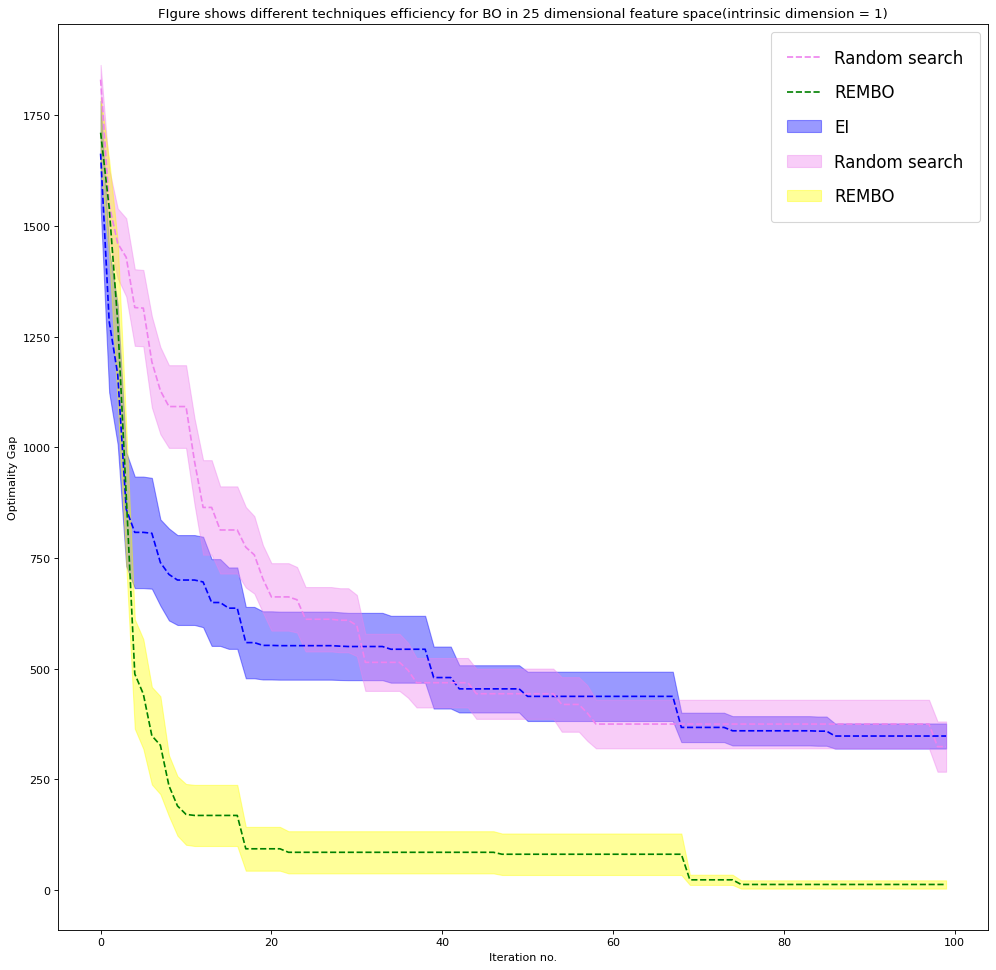

In [69]:
## plot showing optimality gap between max value obtained in each iteration and best value that can be obtained in the bound for two different aquisition functions - PI and EI. 
iters=100
# x = range(iters)
# y = []
# y1 = []
# y2 = []
# for i in range(iters):
#   mean = np.mean(dp_PI[:,i])
#   std = np.std(dp_PI[:,i])
#   dev_up = np.max(dp_PI[:,i])
#   dev_down = np.min(dp_PI[:,i])
#   y.append(mean)
#   y1.append(mean-std/4)
#   y2.append(mean+std/4)
#   # y1.append(dev_up)
  # y2.append(dev_down)
fig = plt.figure(num=1, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
# ax.fill_between(x, y1, y2, color="red", alpha=0.4,label='PI')
# ax.plot(x,y,'--',color='red')
x = range(iters)
y = []
y1 = []
y2 = []
for i in range(iters):
  mean = np.mean(dp_EI[:,i])
  std = np.std(dp_EI[:,i])
  dev_up = np.max(dp_EI[:,i])
  dev_down = np.min(dp_EI[:,i])
  y.append(mean)
  y1.append(mean-std/4)
  y2.append(mean+std/4)

ax.fill_between(x, y1, y2, color="blue", alpha=0.4,label = 'EI')
ax.plot(x,y,'--',color='blue')
ax.legend(loc='upper right', borderpad=1, labelspacing=1,prop={'size':15})
ax.set_ylabel("Optimality Gap")
ax.set_xlabel("Iteration no.")

x = range(iters)
y = []
y1 = []
y2 = []
for i in range(iters):
  mean = np.mean(dp_random[:,i])
  std = np.std(dp_random[:,i])
  dev_up = np.max(dp_random[:,i])
  dev_down = np.min(dp_random[:,i])
  y.append(mean)
  y1.append(mean-std/4)
  y2.append(mean+std/4)

ax.fill_between(x, y1, y2, color="violet", alpha=0.4,label = 'Random search')
ax.plot(x,y,'--',color='violet',label='Random search')
ax.legend(loc='upper right', borderpad=1, labelspacing=1,prop={'size':15})
ax.set_ylabel("Optimality Gap")
ax.set_xlabel("Iteration no.")

x = range(iters)
y = []
y1 = []
y2 = []
for i in range(iters):
  mean = np.mean(dp_rembo[:,i])
  std = np.std(dp_rembo[:,i])
  dev_up = np.max(dp_rembo[:,i])
  dev_down = np.min(dp_rembo[:,i])
  y.append(mean)
  y1.append(mean-std/4)
  y2.append(mean+std/4)

ax.fill_between(x, y1, y2, color="yellow", alpha=0.4,label = 'REMBO')
ax.plot(x,y,'--',color='green',label='REMBO')
ax.legend(loc='upper right', borderpad=1, labelspacing=1,prop={'size':15})
ax.set_ylabel("Optimality Gap")
ax.set_xlabel("Iteration no.")



ax.set_title("FIgure shows different techniques efficiency for BO in 25 dimensional feature space(intrinsic dimension = 1)")

## 

plt.show(1)

In [70]:
print(dp_rembo[:,99])
print(dp_random[:,99])

[  0.           0.           0.           0.           0.
   2.78894145   0.         124.69369174   0.           0.        ]
[198.27988938 851.80350686 248.87343368 181.15669274 475.99390834
 251.72434849 300.4406804   60.70928056 555.4991197  116.88760805]
